##Clustering based on $\sigma_{\epsilon}^2$

In [1]:
import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg
import pandas as pd
%pylab
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
%qtconsole

## Functions used in clustering

In [4]:
def Do_Kalman_Likelihood(y, sigma2obs, sigma2e):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model

    :param y: Observations (K,)
    :param sigma2obs: Variance of observation noise (can be scalar or vector)
    :param sigma2e: Variance of process noise
    :return: x_map, L, marginal_loglikelihood, joint_loglikelihood
    """
    # Build diagonals of information matrix
    sigma2obs *= np.ones(len(y))
    D = 1. / sigma2obs + 2. / sigma2e
    D[-1] = 1. / sigma2obs[-1] + 1. / sigma2e
    B = -np.ones(len(D)) / sigma2e
    B[0] = 0.
    
    # Solve, assuming x_init=0 for simplicity
    #L = sp.linalg.cholesky_banded((D, B), lower=True)
    U = sp.linalg.cholesky_banded((B, D), lower=False)

    x_map = sp.linalg.cho_solve_banded([U, False], y / sigma2obs)

    # Compute joint and marginal probabilities
    joint_loglikelihood = -.5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e +
                                 np.sum((y - x_map)**2 / sigma2obs) +
                                 (len(y) * np.log(2*np.pi*sigma2e * 2*np.pi) + np.sum(np.log(sigma2obs))))
    marginal_loglikelihood = len(y)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [5]:
def Do_Kalman_Likelihood_Bernoulli_LaplaceMAP(dN, sigma2e, tol=1e-8, trials=1.):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model
    computed using Laplace approximation around MAP state.

    :param dN: Observations (K,)
    :param sigma2e: Variance of process noise
    :param tol: Convergence criterion on the gradient of the log-likelihood
    :param trials: Number of trials for binomial observations (1 for Bernoulli)
    :return: x_map, U, marginal_loglikelihood, joint_loglikelihood
    """
    x = np.zeros(dN.shape)
    dN = dN.astype(float)
    while True:
        # Build gradient of joint
        d2x = np.convolve(x, [-1, 2, -1])[1:-1]
        d2x[-1] -= x[-1]
        G = -dN + trials * (1. / (1. + np.exp(-x))) + d2x / sigma2e
        # Build Hessian of joint
        D = trials / (np.exp(x) + 2. + np.exp(-x)) + 2. / sigma2e
        D[-1] -= 1. / sigma2e
        B = -np.ones(len(D)) / sigma2e
        B[0] = 0.
        U = sp.linalg.cholesky_banded((B, D), lower=False)
        # Check convergence
        if np.dot(G, G) < tol:
            x_map = x
            break
        # Update estimate of map
        x -= sp.linalg.cho_solve_banded([U, False], G)

    # Compute joint and marginal probabilities
    joint_loglikelihood = (np.sum(np.log(sp.special.binom(trials, dN)) + dN * x_map - trials * np.log(1 + np.exp(x_map))) -
                           .5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e + len(dN) * np.log(2*np.pi*sigma2e)))
    marginal_loglikelihood = len(dN)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [6]:
def cov_from_chol_precision(U):
    """Given the Cholesky factorization (U) of the posterior precision matrix (J), with U^t * U = J,
    return the tridiagonal part of the covariance matrix.

    :param U: Cholesky factorization (U) of J, given as [0, A; D] where A is the upper diagonal and D the main diagonal
    :return: Cov_tri: Tridiagonal part of the covariance matrix returned as [0, C_i,i+1; C_ii; C_i+1,i, 0]
    """
    assert(U.shape[0] == 2 and U[0,0] == 0)
    A, D = U # Unpack matrix into first (above) diagonal and diagonal
    Cov_tri = np.zeros_like(U)
    C, V = Cov_tri # Obtain _views_ into the first diagonal and diagonal
    # Compute last element of diagonal
    V[-1] = 1. / (D[-1] ** 2)
    # Recursively compute other elements of main diagonal and first diagonal
    for i in range(len(D)-1, 0, -1):
        iD = 1. / D[i-1]
        iDA = iD * A[i]
        N = -iDA * V[i]
        C[i] = N
        V[i-1] = iD ** 2 - N * iDA
    return Cov_tri

## Load data

In [7]:
toydata = False
if toydata:
    trials = 1

    # Generate complex-valued Gaussian random vector
    k = linspace(0,100,3000)
    K = k.shape[0]

    # Real part is an oscillation with period K0
    K0 = 12.5
    c1m = cos(2*pi*(k-((K0)/4))/(K0))

    # Imaginary part is linear
    #c2m = k/100
    c2m = cos(2*pi*(k-(8*K0/4))/(8*K0))

    # normalize cluster 1 mean and culster 2 mean they have the same energy
    #c2m = sqrt(var(c1m)/var(c2m))*c2m

    # Add Gaussian noise (based on real part, which is 0 mean)
    snr = 10 # in dB

    sigma2e = var(c1m) + var(c2m)

    sigma2v = sigma2e*10**(-snr/10)

    y1 = c1m + sqrt(sigma2v)*randn(K) 
    y2 = c2m + sqrt(sigma2v)*randn(K)

    # Generate 10 time series for each cluster

    Y1 = c1m + sqrt(sigma2v)*randn(10,K)

    Y2 = c2m + sqrt(sigma2v)*randn(10,K)

    Y = concatenate((Y1,Y2),axis=0)
else:
    # Load test data
    Y = pd.read_csv('cluster_train_data.csv', header=None).values#[500:540]#800]
    labels = Y[:,0]
    Y = Y[:,1:]
    trials = 50.
    
    sigma2v = 5.0

## Assess amount of observation noise in real data

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 14.5 ms
-4150.10263879


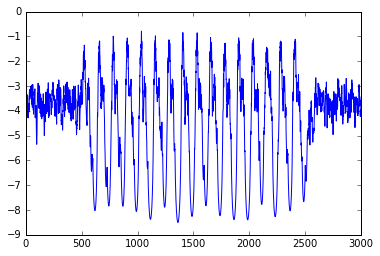

0.000191436736183


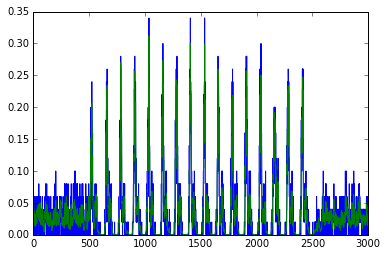

In [9]:
if not toydata:
    # Test Marginal_Likelihood using the Laplace approximation around the MAP
    sigma2e = 0.5
    %time x_map_l, U_l, marginal_loglikelihood_l, joint_loglikelihood_l = Do_Kalman_Likelihood_Bernoulli_LaplaceMAP(Y[0,:], sigma2e, trials=trials)
    print(marginal_loglikelihood_l)
    plt.plot(x_map_l)
    plt.show()
    plt.plot(Y[0,:]/trials)
    plt.plot(np.exp(x_map_l)/(1+np.exp(x_map_l)))

    print(var(Y[0,:]/trials - np.exp(x_map_l)/(1+np.exp(x_map_l))))

## Run clustering

In [10]:
def Cluster_Kalman(Y, sigma2obs, sigma2e_init, prior_clusters, trials=1., verbose=True):
    assert(len(sigma2e_init) == len(prior_clusters))
    C = len(prior_clusters)
    M, K = Y.shape
    posterior_clusters = np.tile(prior_clusters, [M,1]).T
    sigma2e = sigma2e_init
    expect_log_likel_old = np.NaN
    while True:
        sigma2e_new = np.zeros((C, M))
        log_prob_Yi_given_c = np.zeros((C, M))
        for i, Y_i in enumerate(Y):
            for c, sigma2e_c in enumerate(sigma2e):
                x_map, U, marginal_loglik, _ = Do_Kalman_Likelihood(Y_i, sigma2obs, sigma2e_c)
                Cov_tri = cov_from_chol_precision(U)
                sigma2e_new[c,i] = (np.sum(Cov_tri[1]) + np.dot(x_map, x_map) # E[x_k^2]
                                   + np.sum(Cov_tri[1,:-1]) + np.dot(x_map[:-1], x_map[:-1]) # E[x_{k-1}^2]
                                   - 2 * np.sum(Cov_tri[0]) - 2 * np.dot(x_map[1:], x_map[:-1])) / K # E[x_{k-1} * x_k]
                log_prob_Yi_given_c[c,i] = marginal_loglik
        expect_log_likel = np.sum(posterior_clusters * log_prob_Yi_given_c)
        if verbose:
            print(expect_log_likel, sigma2e)
        if (abs(expect_log_likel - expect_log_likel_old) < 1e-6 * abs(expect_log_likel_old)):
            break
        expect_log_likel_old = expect_log_likel
        sigma2e = np.sum(posterior_clusters * sigma2e_new, axis=1) / np.sum(posterior_clusters, axis=1)
        posterior_clusters = np.exp(log_prob_Yi_given_c - np.max(log_prob_Yi_given_c, axis=0)) * prior_clusters[:,None]
        posterior_clusters /= np.sum(posterior_clusters, axis=0)
        prior_clusters = np.sum(posterior_clusters, axis=1) / np.sum(posterior_clusters, axis=None)
    return sigma2e, prior_clusters, posterior_clusters, expect_log_likel

In [11]:
%%time
if toydata:
    #sigma2e_init = np.array([0.01, 0.001])
    sigma2e_init = np.array([0.0001, 0.001])
    #sigma2e_init = np.array([0.1, 0.01])
else:
    sigma2e_init = np.array([1.0, 5.0])

prior_clusters = np.array([0.5, 0.5])
sigma2e, prior_clusters, posterior_clusters, expect_log_likel = Cluster_Kalman(Y, sigma2v, sigma2e_init, prior_clusters, trials=trials)
print('---- Expectation of log_likelihood -----')
print(expect_log_likel)
print('---- Sigma2e -----')
print(sigma2e)
print('---- Prior clusters (estimated) -----')
print(prior_clusters)
print('---- Posterior clusters -----')
print(posterior_clusters)

-138464.629827 [ 1.  5.]
-133457.05858 [ 0.93475021  3.42768611]
-133047.017358 [ 0.84246212  3.31509109]
-132728.460907 [ 0.74789406  3.14250582]
-132477.460103 [ 0.67278398  3.01612283]
-132276.793796 [ 0.61199827  2.92214966]
-132114.398758 [ 0.56201724  2.85146137]
-131981.609869 [ 0.52035703  2.79781587]
-131872.065773 [ 0.48522087  2.75682653]
-131781.006657 [ 0.45528075  2.72534279]
-131704.811104 [ 0.42953655  2.70106191]
-131640.683071 [ 0.40722239  2.68227696]
-131586.435649 [ 0.38774303  2.66770832]
-131540.338671 [ 0.37062968  2.65638808]
-131501.00937 [ 0.35550867  2.64757888]
-131467.327791 [ 0.34207889  2.64071573]
-131430.516153 [ 0.33008933  2.6351836 ]
-131383.193384 [ 0.31661202  2.56340286]
-131342.326439 [ 0.30385866  2.49469085]
-131308.121899 [ 0.2924602   2.44198782]
-131279.149783 [ 0.28223012  2.40127598]
-131254.378188 [ 0.27301315  2.36964748]
-131230.448063 [ 0.26467867  2.34494445]
-131197.308956 [ 0.25628237  2.3065506 ]
-131166.063506 [ 0.24717693  2.249

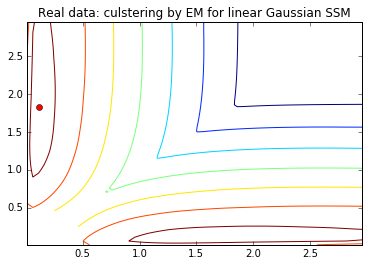

In [12]:
if toydata:
    s2e = np.arange(0.00001, 0.005, .0001)
else:
    s2e = np.arange(0.01,3,0.05)
#print s2e
marginal_loglik = np.zeros_like(s2e)
loglik_s1_s2 = np.zeros([len(s2e) , len(s2e)])
col = ['', 'r', 'g', 'b']
for i, Y_i in enumerate(Y):
    for j in range(len(s2e)):
        marginal_loglik[j] = Do_Kalman_Likelihood(Y_i, sigma2v, s2e[j])[2]
    offset = np.max(marginal_loglik)
    marginal_lik = np.exp(marginal_loglik - offset)
    loglik_s1_s2 += offset + np.log(.5 * (marginal_lik[None,:] + marginal_lik[:,None]))
plt.contour(s2e, s2e, loglik_s1_s2)
plot(sigma2e[0],sigma2e[1],'ro')
if toydata:
    title('Toy data: culstering by EM for linear Gaussian SSM');
else:
    title('Real data: culstering by EM for linear Gaussian SSM');


In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

% matplotlib tk
fig = figure()
ax = fig.gca(projection='3d')
S1e, S2e = np.meshgrid(s2e, s2e)

surf = ax.plot_surface(S1e, S2e, loglik_s1_s2, rstride=1, cstride=1)#, cmap=cm.Accent,
                       #linewidth=0, antialiased=False)
    
#plot(sigma2e[0],sigma2e[1],'ro')

#ax.set_zlim(-25000, -18000)

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
print unravel_index(np.argmax(loglik_s1_s2),loglik_s1_s2.shape)

In [ ]:
print s2e[2], s2e[36]

In [14]:
#%matplotlib inline
x_map, U, marginal_loglikelihood, joint_loglikelihood = Do_Kalman_Likelihood(Y[0,:],sigma2v,0.11)
plot(Y[0,:])
plot(x_map)


In [15]:
marginal_loglikAll = np.zeros((Y.shape[0],s2e.shape[0]))
print(marginal_loglikAll.shape)

for i in range(Y.shape[0]):
    for j in range(len(s2e)):
        marginal_loglikAll[i,j] = Do_Kalman_Likelihood(Y[i,:], sigma2v, s2e[j])[2]
    
plot(s2e,marginal_loglikAll[19,:])


(20, 60)


In [ ]:
print Y.shape
print sigma2v
print s2e.shape[0]

In [ ]:
plot(Y[2,:])

## Compare w Particle Filter

In [16]:
numcells = 20 # number of cells
numsigs = len(s2e) # number of values of sigma
numsmcs = 10 # number of smc steps ran by Pierre

# load up sigma file
#sig2s = pd.read_csv('r_thetas.csv')
#sig2mat = sig2s['x'].values.reshape(numsigs,numsmcs)

# build a dicitionary with 20 keys to store the data for each neuron
# value are matrices w the likelihood data

llhd = {}
llhdmean = zeros((numcells,numsigs))
for i in range(numcells):
    llhd[i] = pd.read_csv('./R_Results_Gaussian/row_%d_ll_gaussian.csv' % i)['x'].values.reshape(numsigs,numsmcs)
    llhdmean[i] = mean(llhd[i],axis=1)
    #print llhddict[i].shape
    
# plot the mofos
for i in range(numcells):
    if i < 10:
        plot(s2e,llhdmean[i],'g')
    else:
        plot(s2e,llhdmean[i],'b')

In [17]:
print unravel_index(np.argmax(loglik_s1_s2),loglik_s1_s2.shape)

SyntaxError: invalid syntax (<ipython-input-17-66f7777ee02f>, line 1)

In [ ]:
print s2e[2], s2e[43]

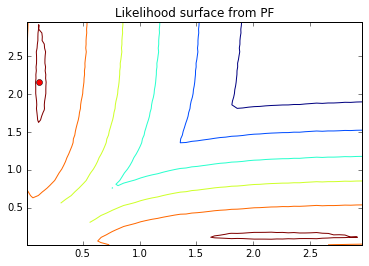

In [18]:
%matplotlib inline
for i in range(numcells):
    offset = np.max(llhdmean[i])
    marginal_lik = np.exp(llhdmean[i] - offset)
    loglik_s1_s2 += offset + np.log(.5 * (marginal_lik[None,:] + marginal_lik[:,None]))
plt.contour(s2e, s2e, loglik_s1_s2)
plot(s2e[2],s2e[43],'ro')
title('Likelihood surface from PF')

## Likelihood computation with the Kalman filter

In [25]:
def KalFilt(y,sigma2v,sigma2e,xbar0,sigma20):
    
    # signal length
    K = y.shape[0]
    
    #filter data structures
    xprior = zeros(K,dtype=float) # one-step prediction: xprior[k] = x_{k|k-1}
    s2prior = zeros(K,dtype=float) # \sigma^2_{k|k-1}
    
    xpost = zeros(K,dtype=float) # posterior at time k: xpost[k] = x_{k|k}
    s2post = zeros(K,dtype=float) # \sigma^2_{k|k}

    for k in range(K):
        
        if k == 1:
            xprior[k] = xbar0
            s2prior[k] = sigma20 + sigma2e
        else:
            xprior[k] = xpost[k-1]
            s2prior[k] = s2post[k-1] + sigma2e
        
        ck = s2prior[k]/(sigma2v + s2prior[k])
        
        xpost[k] = xprior[k] + ck*(y[k]-xprior[k])
        
        s2post[k] = 1.0/(1.0/sigma2v + 1.0/s2prior[k])
        
    v = (sigma2v + s2prior)
    #llhd = sum(log(normpdf(y,xprior, v**0.5 )))
    llhd = -K/2. * np.log(2*np.pi) - .5*np.sum(np.log(v)) - .5 * np.sum((y - xprior)**2 / v)

    return (xpost,s2post,llhd,)
    return (xpost,s2post)
    return llhd

-6205.35515469 -6205.1960466 -7450.17775602


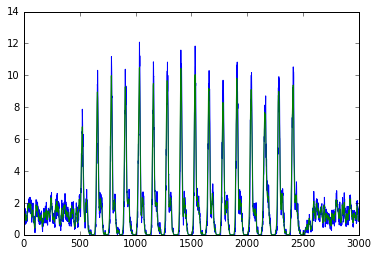

In [26]:
xpost, s2post, llhdKal, = KalFilt(Y[0,:],sigma2v,0.5,0.0,0.0)
x_map, U, llhdLuca, joint = Do_Kalman_Likelihood(Y[0,:], sigma2v, 0.5)
print(llhdKal, llhdLuca, joint)
plt.plot(xpost)
plt.plot(x_map)

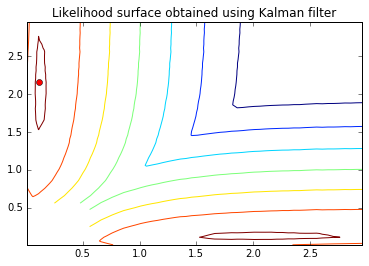

In [27]:
for i, Y_i in enumerate(Y):
    for j in range(len(s2e)):
        marginal_loglik[j] = KalFilt(Y_i, sigma2v, s2e[j],0.0,0.0)[2]
    offset = np.max(marginal_loglik)
    marginal_lik = np.exp(marginal_loglik - offset)
    loglik_s1_s2 += offset + np.log(.5 * (marginal_lik[None,:] + marginal_lik[:,None]))
plt.contour(s2e, s2e, loglik_s1_s2)
plot(s2e[2],s2e[43],'ro')
title('Likelihood surface obtained using Kalman filter')

In [ ]:
print unravel_index(np.argmax(loglik_s1_s2),loglik_s1_s2.shape)

In [ ]:
print s2e[2], s2e[43]

In [ ]:
sigma2v

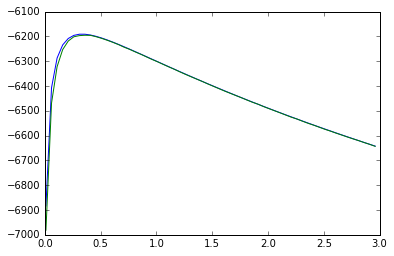

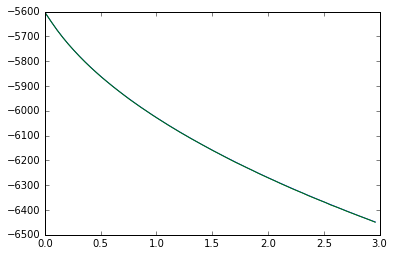

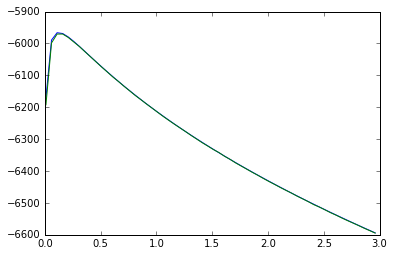

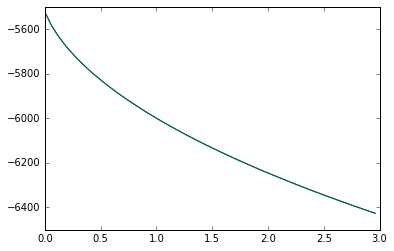

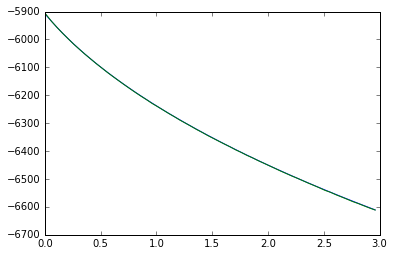

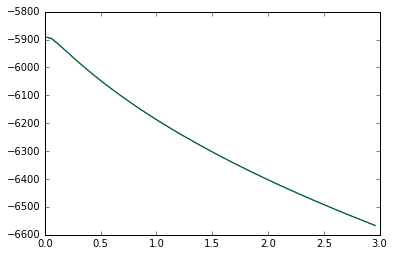

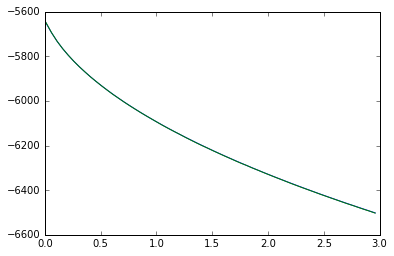

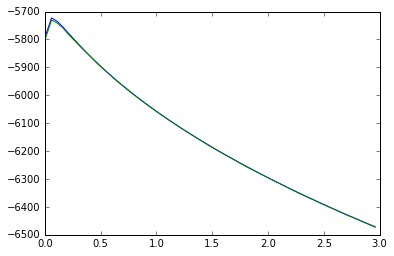

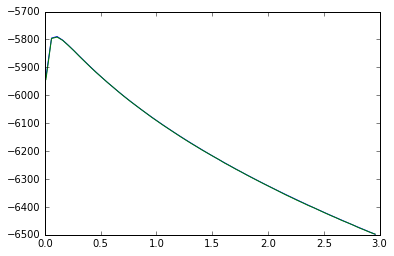

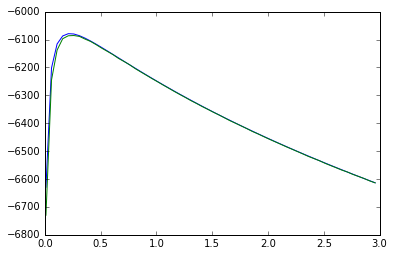

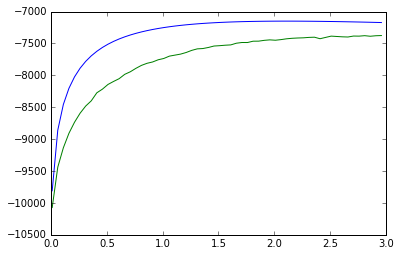

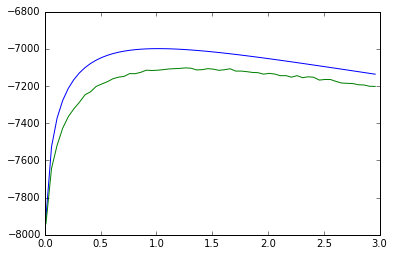

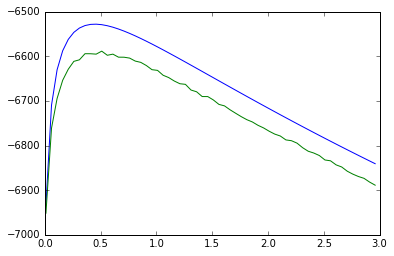

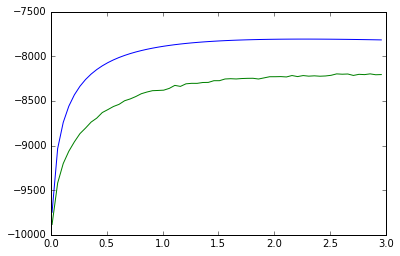

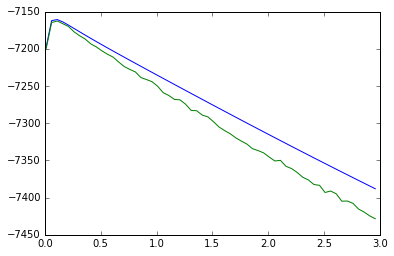

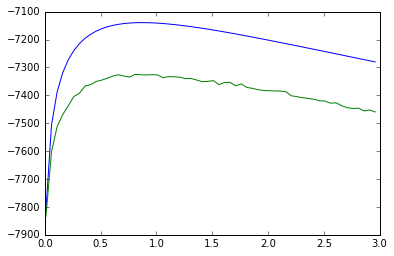

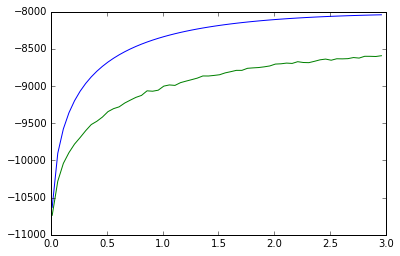

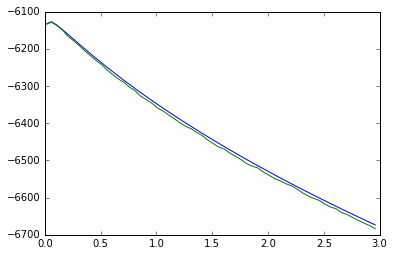

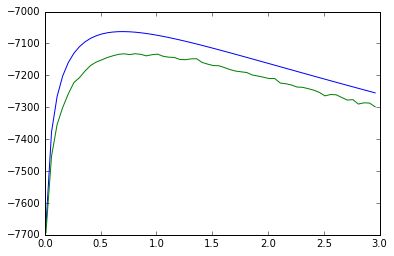

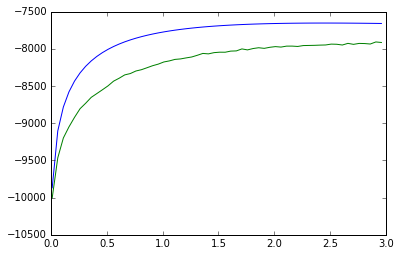

In [35]:
marginal_loglik = np.zeros_like(s2e)
for unit in range(20):
    for j in range(len(s2e)):
        marginal_loglik[j] = Do_Kalman_Likelihood(Y[unit], sigma2v, s2e[j])[2]

    plt.plot(s2e, marginal_loglik)
    plt.plot(s2e, llhdmean[unit])
    plt.show()